You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import os
import pandas as pd
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


In [3]:
def NGD_TK_AS(T,epsilon, omegastar, deltastar, tau_y, Bmp, NoDelay = False):
    if NoDelay: return -Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kt = -Bmp*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar)
    return np.convolve(x, Kt, 'full')[:len(T):50]

In [4]:
def NGD_TK(T, alpha, beta, g, tau_y, Amp, ds = 1, NoDelay = False):
    dt = np.mean(np.diff(T))
    dt = dt/ds
    T = np.arange(0, T[-1]+dt, dt)
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    if NoDelay: 
        s = np.zeros(len(T))
        s[0] = 1
    else:
        s = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+(s[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return -Amp*y[::ds]/dt

In [5]:
def ParaTrans(ASparadict):     # because of overfitting, I assume alpha = mag*beta
    for k in ASparadict.keys():
        globals()[k] = ASparadict[k]
    global beta, alpha, g, Amp 
    
    beta = epsilon-omegastar*np.tan(deltastar)
    alpha = epsilon+omegastar*np.tan(deltastar)
    g = omegastar**2 *(1+np.tan(deltastar)**2)
    Amp = Bmp*np.cos(deltastar)
    DiffParadict = {'alpha':[], 'beta':[],  'g':[], 'tau_y':[], 'Amp':[], 'error':[]}
    for k in DiffParadict.keys():
        DiffParadict[k] = globals()[k]
    return DiffParadict

# Load Experimental data

## select files and channels

### From Exp

In [6]:
cn = 41
dt = 0.01
TKtaxis = np.arange(0,0.8,dt)

In [7]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGDASpara.npz', allow_pickle=True)
ASparadict = loadfiles['para_dict'][()]
DiffPara_dict = ParaTrans(ASparadict)

-0.0006352127467746828 -0.02306617099598807


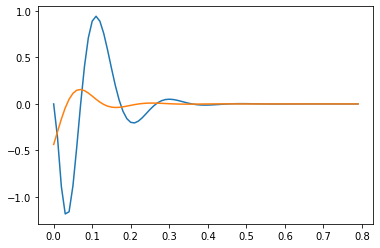

In [8]:
TK = NGD_TK_AS(TKtaxis, *pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1][:-1])
plt.plot(TKtaxis, TK)
longTK = np.append(np.zeros(len(TK)-1), TK)
TKnD = NGD_TK_AS(TKtaxis, *pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1][:-1],  NoDelay = True)
plt.plot(TKtaxis, TKnD/10)
longTKnD = np.append(np.zeros(len(TKnD)), TKnD[1:])
print(sum(TK)*dt, sum(TKnD)*dt)

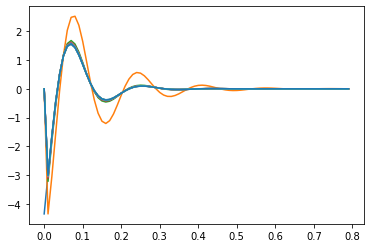

In [9]:
dt = 0.01
TKtaxis = np.arange(0,0.8,dt)
plt.plot(TKtaxis, TKnD)
for ds in np.arange(1,50,5):
    plt.plot(TKtaxis, NGD_TK(TKtaxis, alpha[cn-1], beta[cn-1], g[cn-1],  0,Amp[cn-1], ds, NoDelay = True))

In [10]:
tau_y = pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1]['tau_y']

In [11]:
1/(beta[cn-1]+1)

0.9331113148606209

In [12]:
Fc_list = [2,4,7,10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

In [13]:
Dt = 0.01
v_list = [np.append(np.zeros(int(Dt/dt)), x[int(Dt/dt):]-x[:-int(Dt/dt)])/Dt  for x in x_list]
tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [14]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.534, 0.432, 0.405, 0.395]

In [15]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

# Real Spike

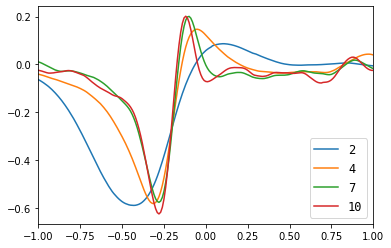

In [16]:
for i in range(len(x_list)):
    plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(x_list[i], rstate_list[i], 'same')
                                                        /np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

## Plot MI

In [17]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

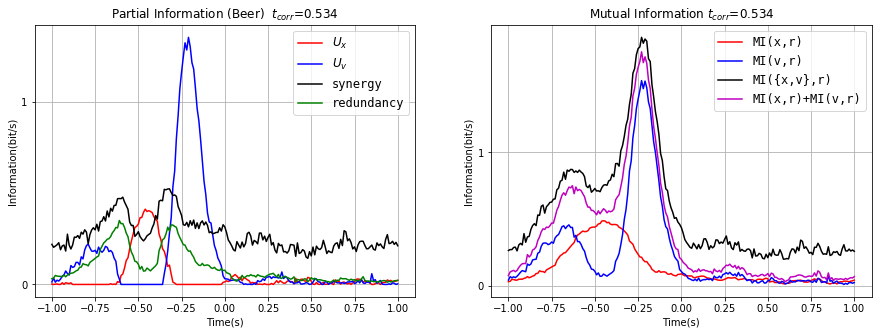

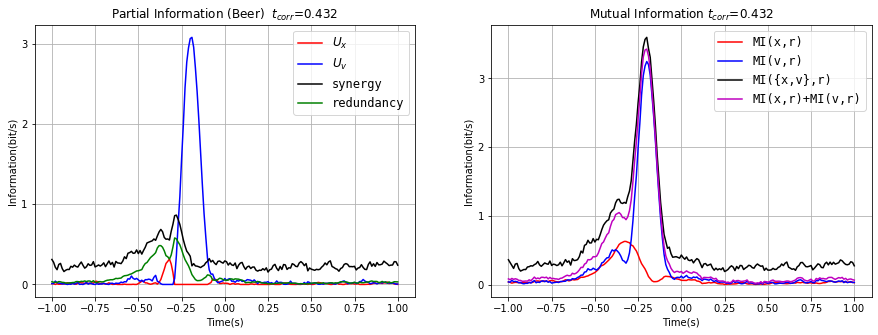

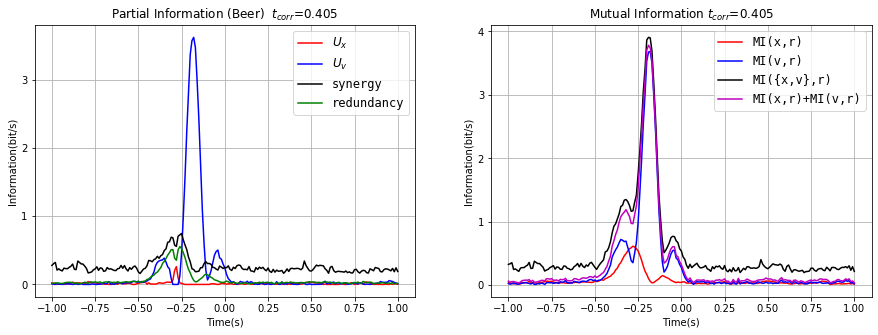

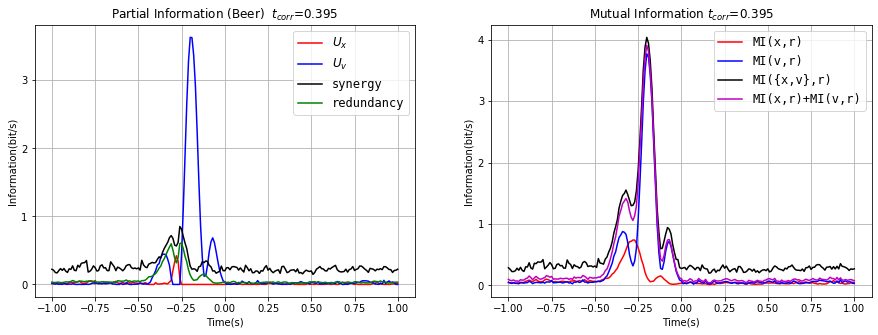

In [18]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

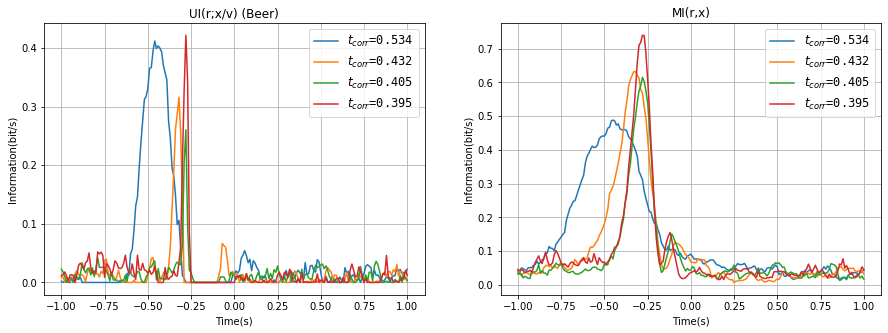

In [19]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# Fake Spike from TK

In [20]:
fr_list = [np.convolve(x*2+10, longTK , 'same')*dt for x in x_list]
frnd_list = [np.convolve(x*2+10, longTKnD , 'same')*dt for x in x_list]

(150, 160)

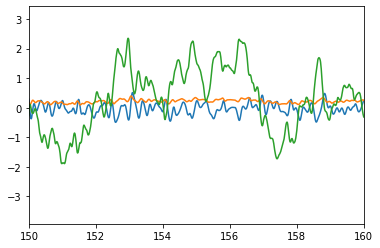

In [21]:
i = 3
plt.plot(T_list[i], 5*fr_list[i])
plt.plot(T_list[i], frnd_list[i])
plt.plot(T_list[i], x_list[i])
plt.xlim([150, 160])

-0.5262102757392227 -27.999804435706018
-0.5216658382657474 -19.6193192461191
0.019221779233811465 0.7504330381672126
0.10386802887745794 2.8069749530402426


Text(0.5, 0, 'centered-normalized threshold')

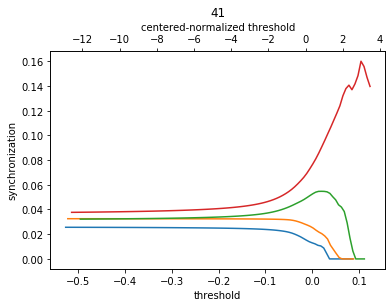

In [22]:
for i in range(len(x_list)):
    thetas = np.linspace(min(fr_list[i]), max(fr_list[i]), 100, endpoint = False)
    sync = [sum(rstate_list[i]*NL(fr_list[i],theta)/sum(NL(fr_list[i],theta))) for theta in thetas]
    plt.plot(thetas, sync)
#     ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
    print(thetas[np.argmax(sync)], (thetas[np.argmax(sync)]-np.mean(fr_list[i]))/np.std(fr_list[i]))
    
plt.title(str(cn))
plt.xlabel('threshold')
plt.ylabel('synchronization')

ax2 = plt.gca().twiny()
ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
ax2.plot(np.linspace(min(ncfc), max(ncfc), 100), np.zeros(100)) # Create a dummy plot
ax2.lines = []
ax2.set_xlabel('centered-normalized threshold')

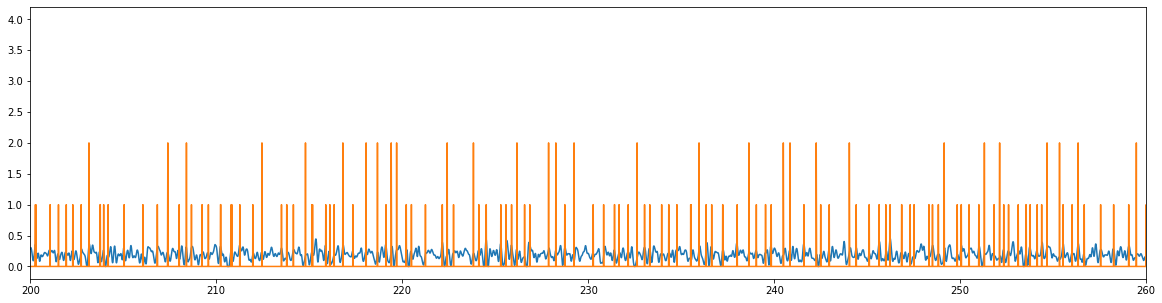

In [23]:
plt.plot(T_list[i], 2*NL(fr_list[i],-0.1))
plt.plot(T_list[i], rstate_list[i])
plt.xlim([200, 260])
plt.gcf().set_size_inches(20, 5)

-0.5370641824462508 -16.6801057885919
0.3378864675213683 2.8057628012134788
0.3784324960062244 3.3081948775053593
0.4000486652630355 3.435440087422812


Text(0.5, 0, 'centered-normalized threshold')

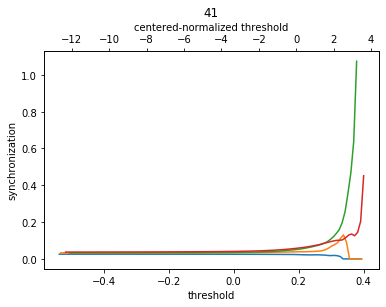

In [24]:
DelayShift = int(tau_y/dt+.5)
for i in range(len(x_list)):
    thetas = np.linspace(min(frnd_list[i]), max(frnd_list[i]), 100, endpoint = False)
    sync = [sum(rstate_list[i][DelayShift:]*NL(frnd_list[i][:-DelayShift],theta)/sum(NL(frnd_list[i],theta))) for theta in thetas]
    plt.plot(thetas, sync)
#     ncfc = (fr_list[i]-np.mean(fr_list[i]))/np.std(fr_list[i])
    print(thetas[np.argmax(sync)], (thetas[np.argmax(sync)]-np.mean(frnd_list[i]))/np.std(frnd_list[i]))
    
plt.title(str(cn))
plt.xlabel('threshold')
plt.ylabel('synchronization')

ax2 = plt.gca().twiny()
ncfc = (frnd_list[i]-np.mean(frnd_list[i]))/np.std(frnd_list[i])
ax2.plot(np.linspace(min(ncfc), max(ncfc), 100), np.zeros(100)) # Create a dummy plot
ax2.lines = []
ax2.set_xlabel('centered-normalized threshold')

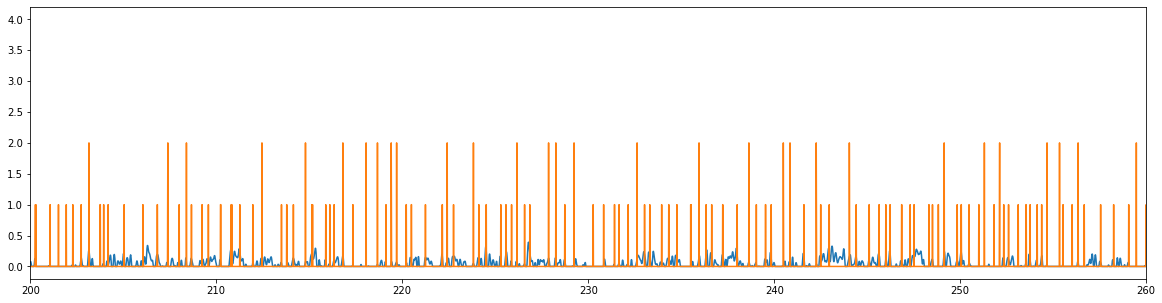

In [25]:
plt.plot(T_list[i][DelayShift:], 2*NL(frnd_list[i][:-DelayShift],np.mean(frnd_list[i])))
plt.plot(T_list[i][DelayShift:], rstate_list[i][DelayShift:])
plt.xlim([200, 260])
plt.gcf().set_size_inches(20, 5)

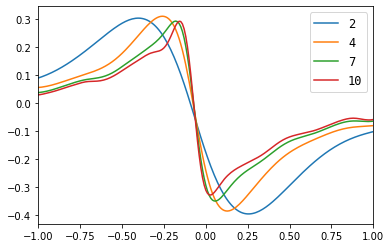

In [26]:
for i in range(len(x_list)):
    plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(x_list[i], NL(fr_list[i],-0.025), 'same')
                                                        /np.correlate(np.ones_like(x_list[i]), NL(fr_list[i],-0.025), 'same'))
#     plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(np.ones_like(x_list[i]), fr_list[i], 'same'))
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

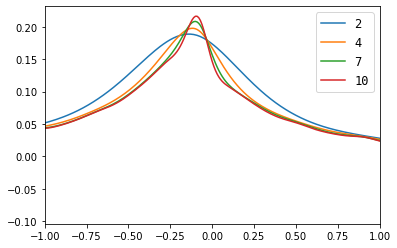

In [27]:
for i in range(len(x_list)):
    plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(x_list[i], NL(frnd_list[i],-0.025), 'same')
                                                        /np.correlate(np.ones_like(x_list[i]), NL(frnd_list[i],-0.025), 'same'))
#     plt.plot(T_list[i]-T_list[i][int(len(T_list[i])/2)], np.correlate(np.ones_like(x_list[i]), fr_list[i], 'same'))
    
plt.xlim([-1, 1])
plt.legend( Fc_list , loc='best', prop={'size': 'large', 'family': 'monospace'})

## Plot MI w/ Delay

In [28]:
frstate_list = [0]*len(x_list)
theta = -0.01
for i in range(len(x_list)):
    theta = np.mean(fr_list[i])
    r = NL(fr_list[i], theta)
    ratio = sum(r)/T_list[i][-1]/10
    FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
    frstate_list[i], _ = np.histogram(FakeSpike, np.append(0,T_list[i]))

In [29]:
window = [-1,1] # second
Model_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Model_Information_list[i] = PIfunc(frstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Model_Information_list.copy()

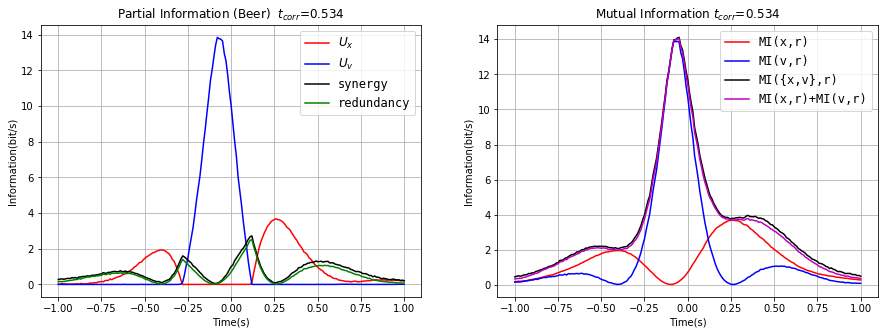

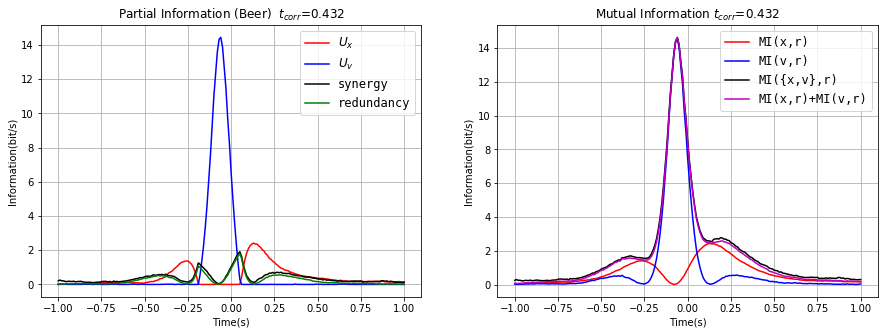

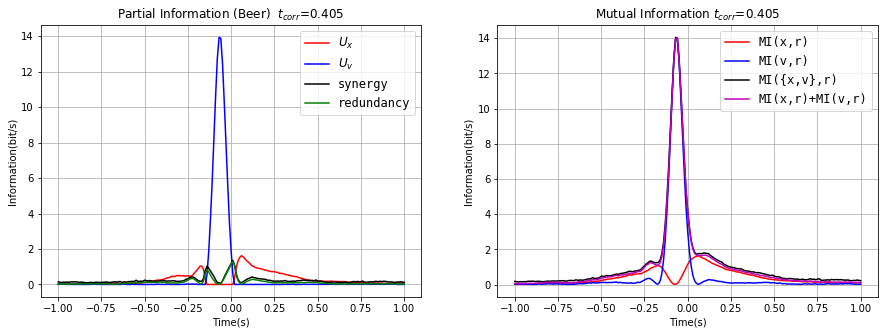

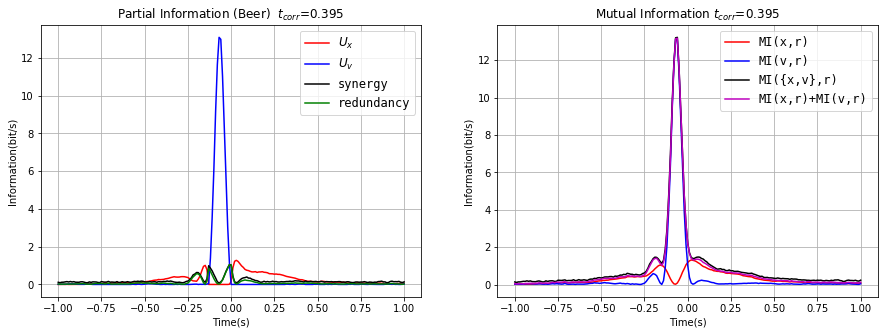

In [30]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

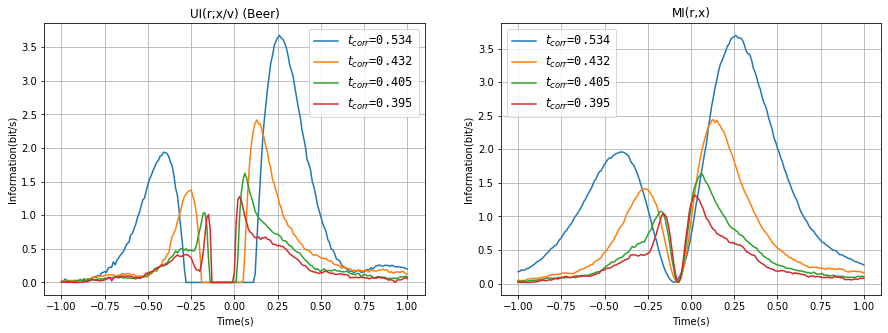

In [31]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

## Plot MI w/o Delay

In [32]:
frndstate_list = [0]*len(x_list)
theta = -0.7
for i in range(len(x_list)):
    theta = np.mean(frnd_list[i])
    r = NL(frnd_list[i], theta)
    ratio = sum(r)/T_list[i][-1]/10
    FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
    frndstate_list[i], _ = np.histogram(FakeSpike, np.append(0,T_list[i]))

In [33]:
window = [-1,1] # second
ModelnD_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, ModelnD_Information_list[i] = PIfunc(frndstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = ModelnD_Information_list.copy()

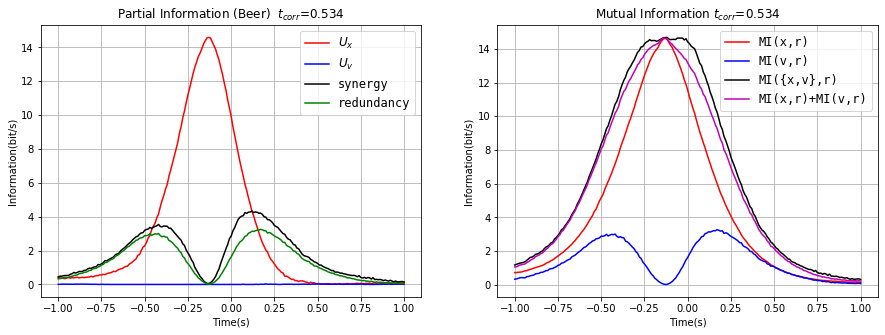

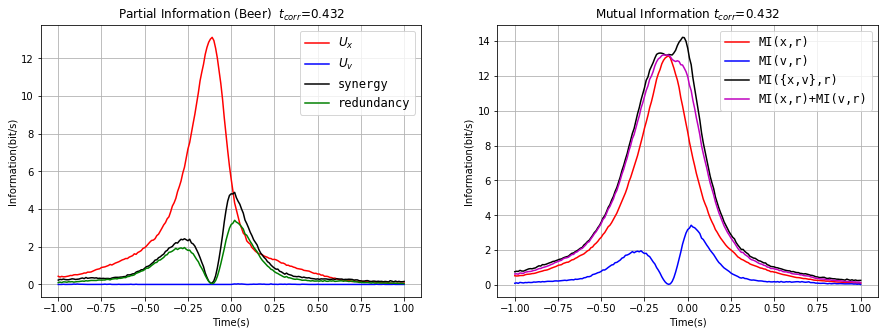

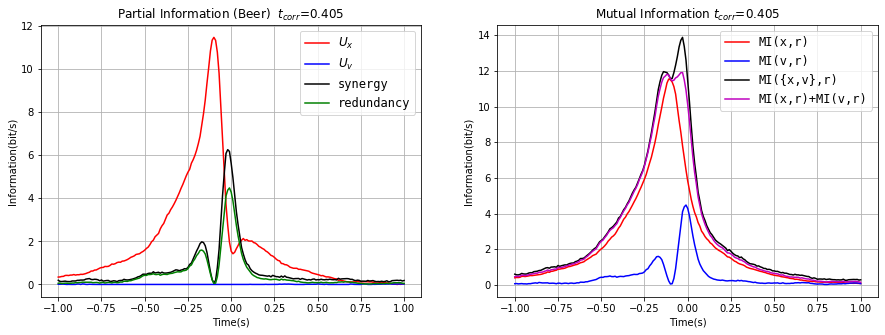

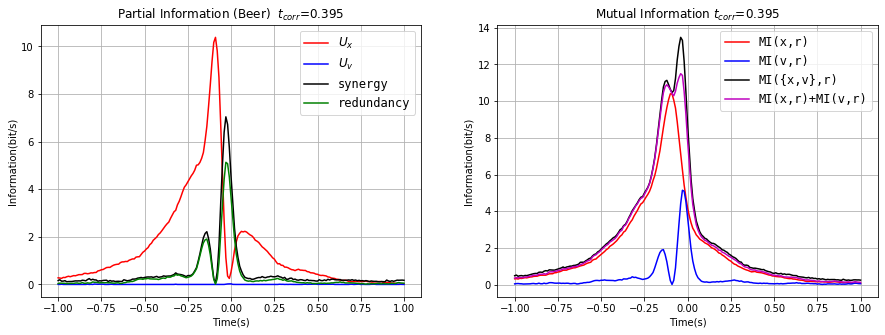

In [34]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

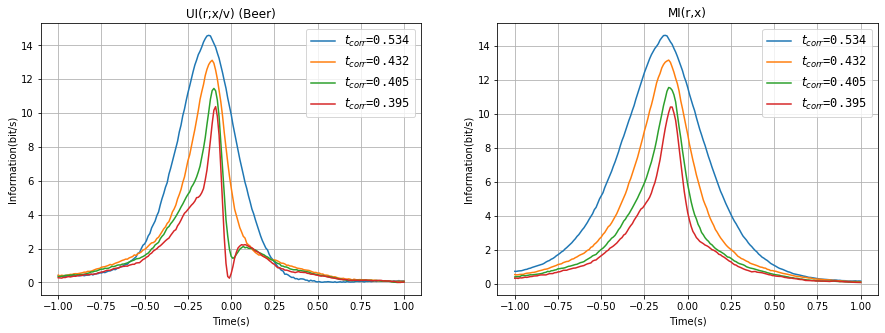

In [35]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

# Compare 

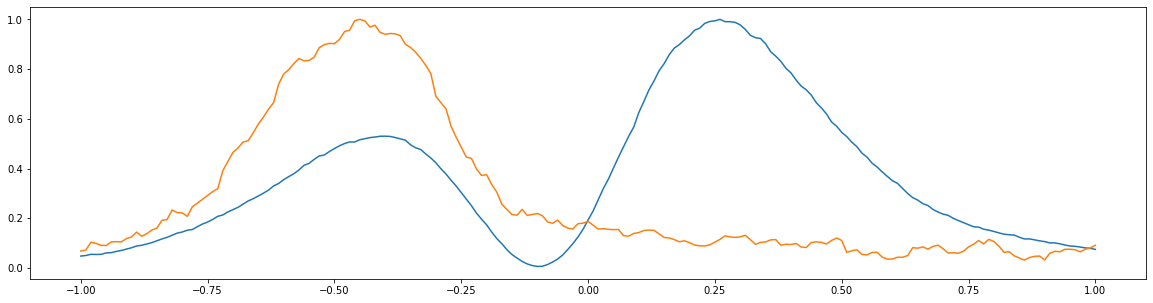

In [36]:
i = 0
fIx = Model_Information_list[i][('Beer','UIx')]+Model_Information_list[i][('Beer','Red')]
plt.plot(timeshift,fIx/max(fIx))
rIx = Real_Information_list[i][('Beer','UIx')]+Real_Information_list[i][('Beer','Red')]
plt.plot(timeshift,rIx/max(rIx))
plt.gcf().set_size_inches(20, 5)